#Doing original problem on Dog Breeding (Keras)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!mkdir /root/.kaggle

In [3]:
!mkdir /content/.kaggle

In [4]:
import json
token = {"username":"wasaequreshi","key":"187049dd5c82981337bb92b53c0bb360"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [5]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [6]:
# !kaggle config set -n path -v{/content}

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets list -s dog-breed-identification

ref                                              title                                 size  lastUpdated          downloadCount  
-----------------------------------------------  -----------------------------------  -----  -------------------  -------------  
dansbecker/dog-breed-identification              dog breed identification             834KB  2019-03-18 15:54:45            666  
selfishgene/youtube-faces-with-facial-keypoints  YouTube Faces With Facial Keypoints     0B  2020-05-25 22:53:33           7424  
muzammilhussain89/dog-breed-identification       Dog Breed Identification              12MB  2020-07-17 02:58:23             19  
carlosmiao/dogbreedidentification                dog-breed-identification             691MB  2021-02-06 09:28:26             66  
vkehfdl1/dog-breed-classification                Dog breed classification             649MB  2020-11-14 05:21:14             25  
ram187/dog-breed-identification                  Dog Breed Identification             691M

In [9]:
!kaggle datasets download -d carlosmiao/dogbreedidentification 

 98% 680M/691M [00:04<00:00, 135MB/s]
100% 691M/691M [00:04<00:00, 164MB/s]


In [10]:
# unzip
import zipfile
def unzip_images():
  with zipfile.ZipFile('dogbreedidentification.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [11]:
unzip_images()

In [12]:
import glob
filelist = glob.glob('train/*.jpg')

In [13]:
import numpy as np
from PIL import Image
x = np.array([np.array(Image.open(fname).resize((180,180))) for fname in filelist])

In [14]:
import csv

with open('labels.csv', newline='') as csvfile:
    labels = list(csv.reader(csvfile))

new_labels = []
for label in labels:
  new_labels.append(label[1])
new_labels = new_labels[1:]
new_labels[0]

'boston_bull'

In [15]:
l1 = []
  
# taking an counter
count = 0
  
# travesing the array
for item in new_labels:
    if item not in l1:
        count += 1
        l1.append(item)
print("No of unique items are:", count)


No of unique items are: 120


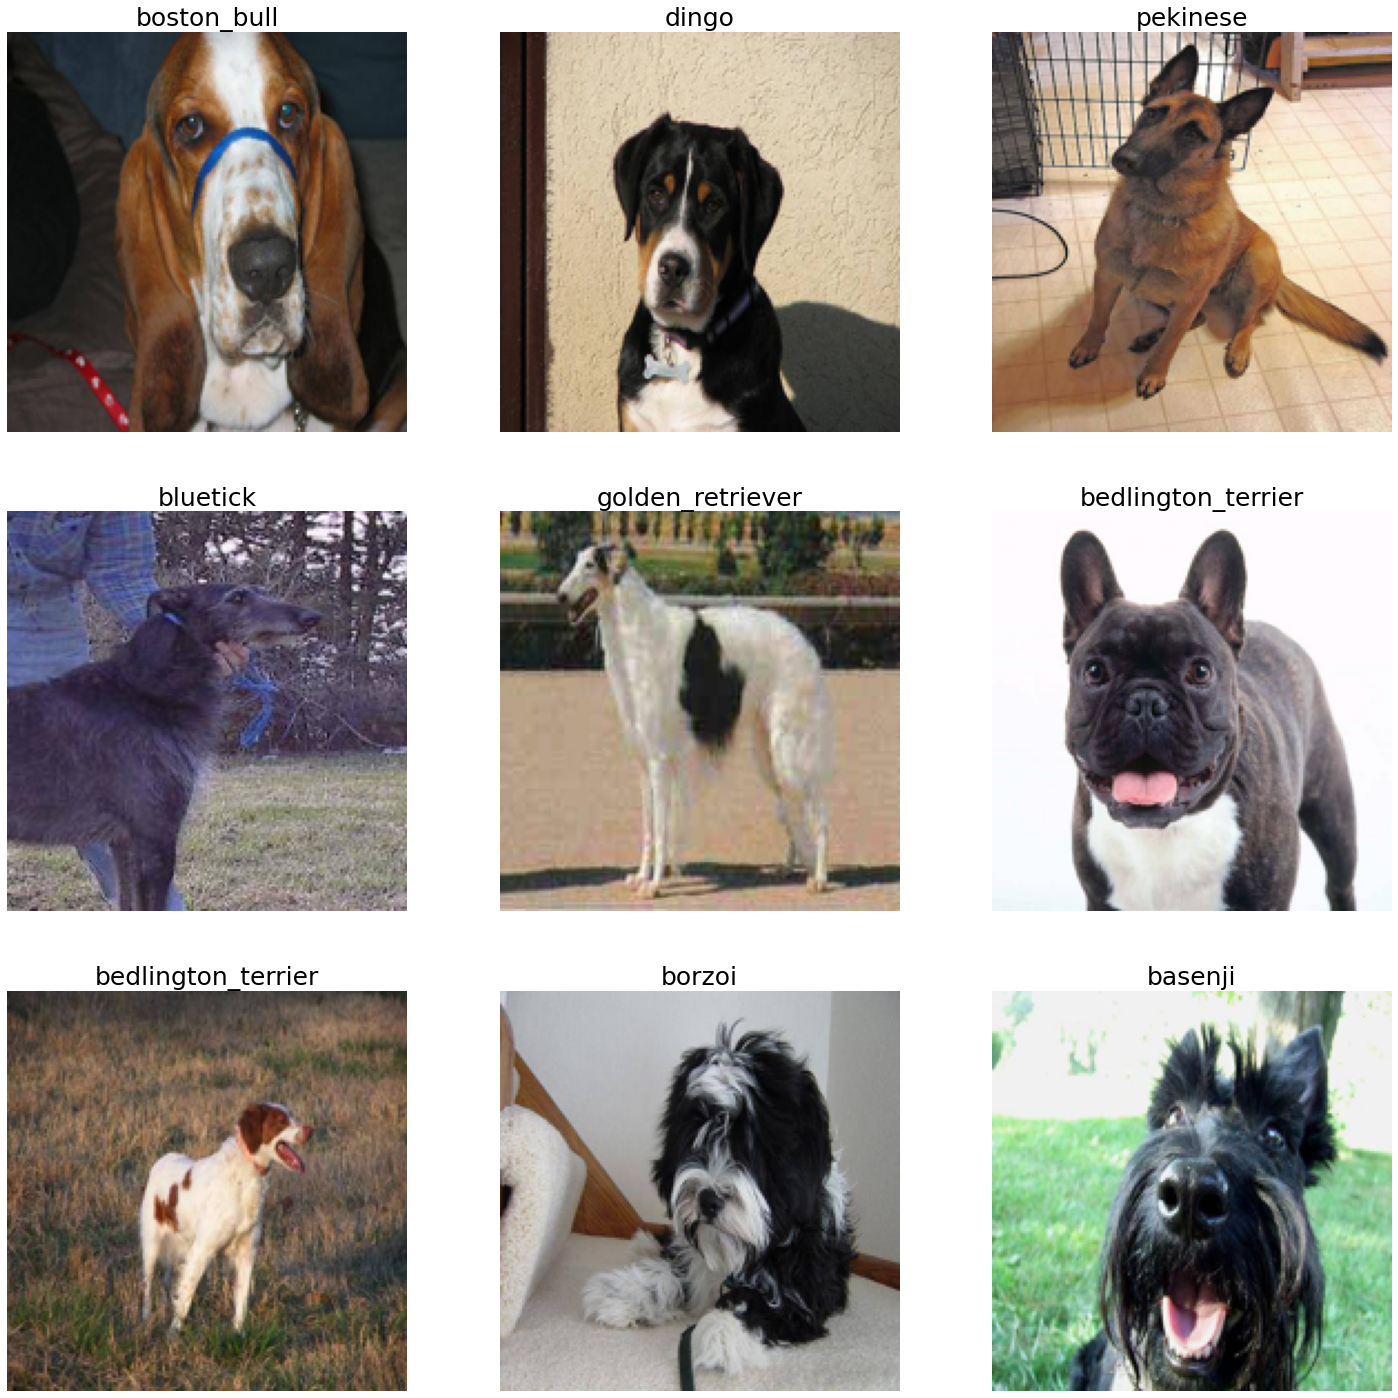

In [16]:
import matplotlib.pyplot as plt
import numpy as np

f, axarr = plt.subplots(3,3)
f.set_figwidth(25)
f.set_figheight(25)
i = 0
for j in range(3):
  for k in range(3):
    font = {'fontsize': 25}
    axarr[j,k].set_title(new_labels[i], font)
    axarr[j,k].imshow(x[i])
    axarr[j,k].axis('off')
    i = i + 1

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


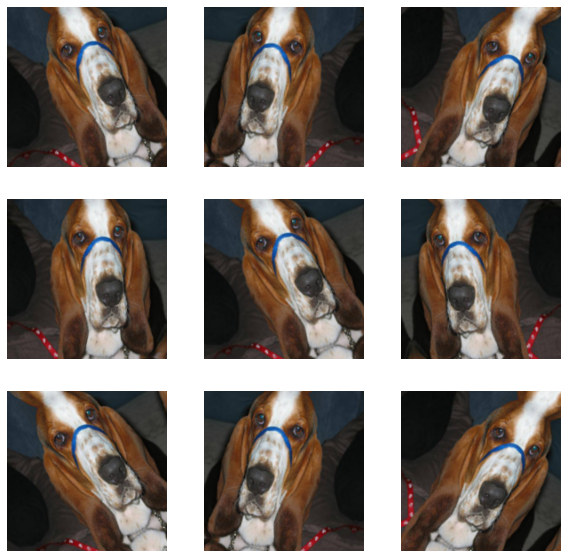

In [18]:
plt.figure(figsize=(10, 10))
for i in range(3):
    for i in range(9):
        augmented_images = data_augmentation(x)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

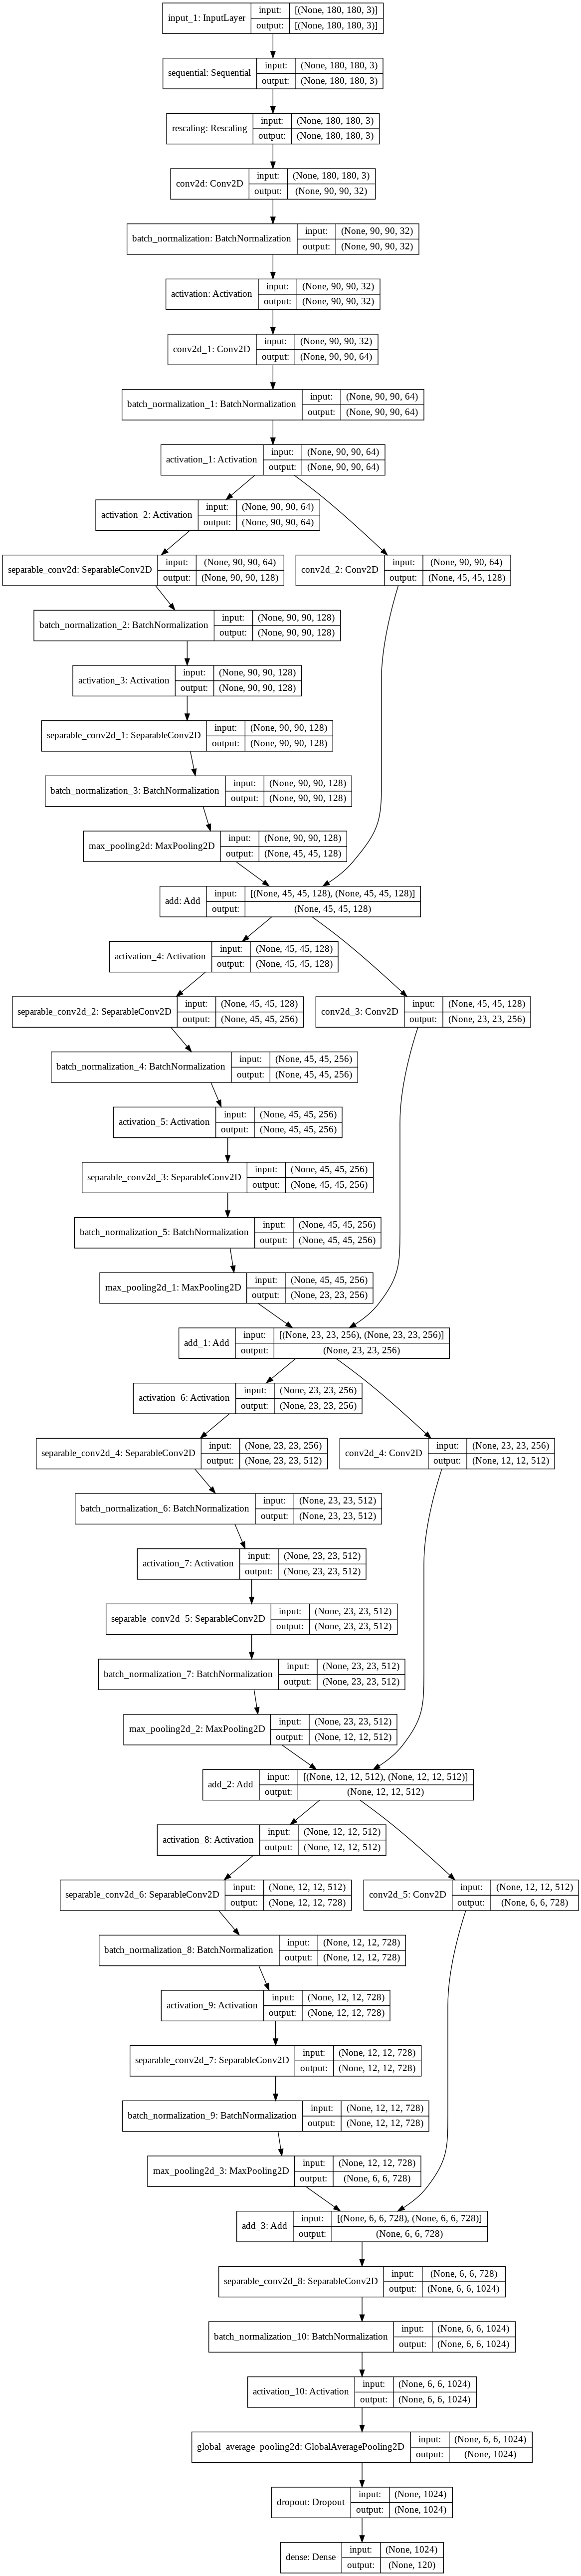

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size = (180,180)
model = make_model(input_shape=image_size + (3,), num_classes=count)
keras.utils.plot_model(model, show_shapes=True)

In [20]:
one_hot_encoded = {}
i = 0
final_array = []
for label in new_labels:
  if label not in one_hot_encoded:
    one_hot_encoded[label] = i
    i = i + 1
  final_array.append(one_hot_encoded[label])

In [21]:
# final_array
# a = np.zeros(count)
final_final_array = []
for item in final_array:
  a = np.zeros(count, dtype=np.int)
  a[item] = 1
  final_final_array.append(a)

In [22]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    x, np.array(final_final_array), epochs=epochs, callbacks=callbacks,
)

Epoch 1/5
320/320 [==============================] - 74s 175ms/step - loss: 5.1504 - accuracy: 0.0099
Epoch 2/5
320/320 [==============================] - 55s 173ms/step - loss: 4.8680 - accuracy: 0.0074
Epoch 3/5
320/320 [==============================] - 55s 173ms/step - loss: 4.8111 - accuracy: 0.0123
Epoch 4/5
320/320 [==============================] - 56s 173ms/step - loss: 4.7987 - accuracy: 0.0092
Epoch 5/5
320/320 [==============================] - 55s 173ms/step - loss: 4.7844 - accuracy: 0.0089


##Original Problem (Keras)

In [23]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
# !kaggle datasets list -s dog-breed-identification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   114M      0  0:00:06  0:00:06 --:--:--  124M


In [24]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 dogbreedidentification.zip   'readme[1].txt'	       save_at_4.h5
 kagglecatsanddogs_3367a.zip   sample_data	       save_at_5.h5
 labels.csv		       sample_submission.csv   test
 model.png		       save_at_1.h5	       train
'MSR-LA - 3467.docx'	       save_at_2.h5
 PetImages		       save_at_3.h5


In [25]:
!ls PetImages/Cat

0.jpg	   11608.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10000.jpg  11609.jpg  1967.jpg	3574.jpg  5181.jpg  678.jpg   8397.jpg
10001.jpg  1160.jpg   1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10002.jpg  11610.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10003.jpg  11611.jpg  196.jpg	3577.jpg  5184.jpg  6792.jpg  839.jpg
10004.jpg  11612.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  83.jpg
10005.jpg  11613.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10006.jpg  11614.jpg  1972.jpg	357.jpg   5187.jpg  6795.jpg  8401.jpg
10007.jpg  11615.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10008.jpg  11616.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jpg
10009.jpg  11617.jpg  1975.jpg	3582.jpg  518.jpg   6798.jpg  8404.jpg
1000.jpg   11618.jpg  1976.jpg	3583.jpg  5190.jpg  6799.jpg  8405.jpg
10010.jpg  11619.jpg  1977.jpg	3584.jpg  5191.jpg  679.jpg   8406.jpg
10011.jpg  1161.jpg   1978.jpg	3585.jpg  5192.jpg  67.jpg    8407.jpg
10012.jpg  11620.jpg  1979

In [26]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [27]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


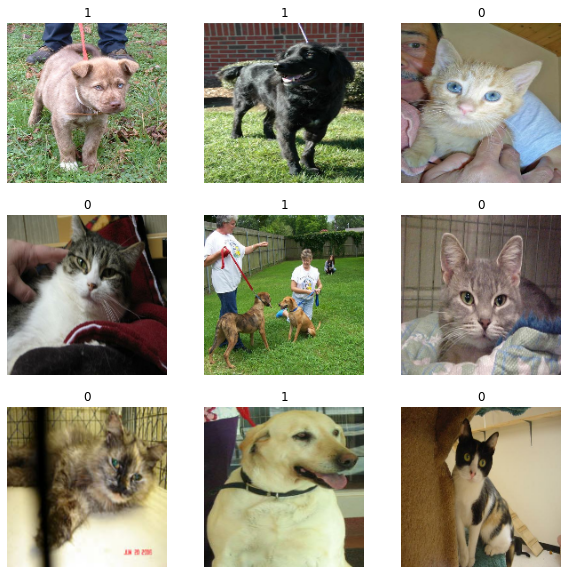

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

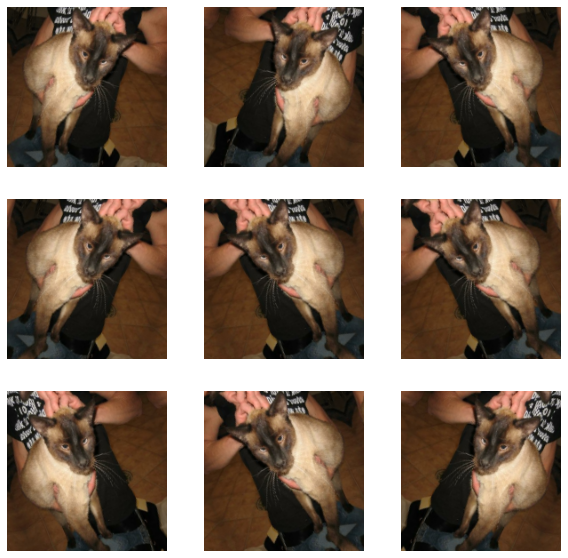

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [31]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

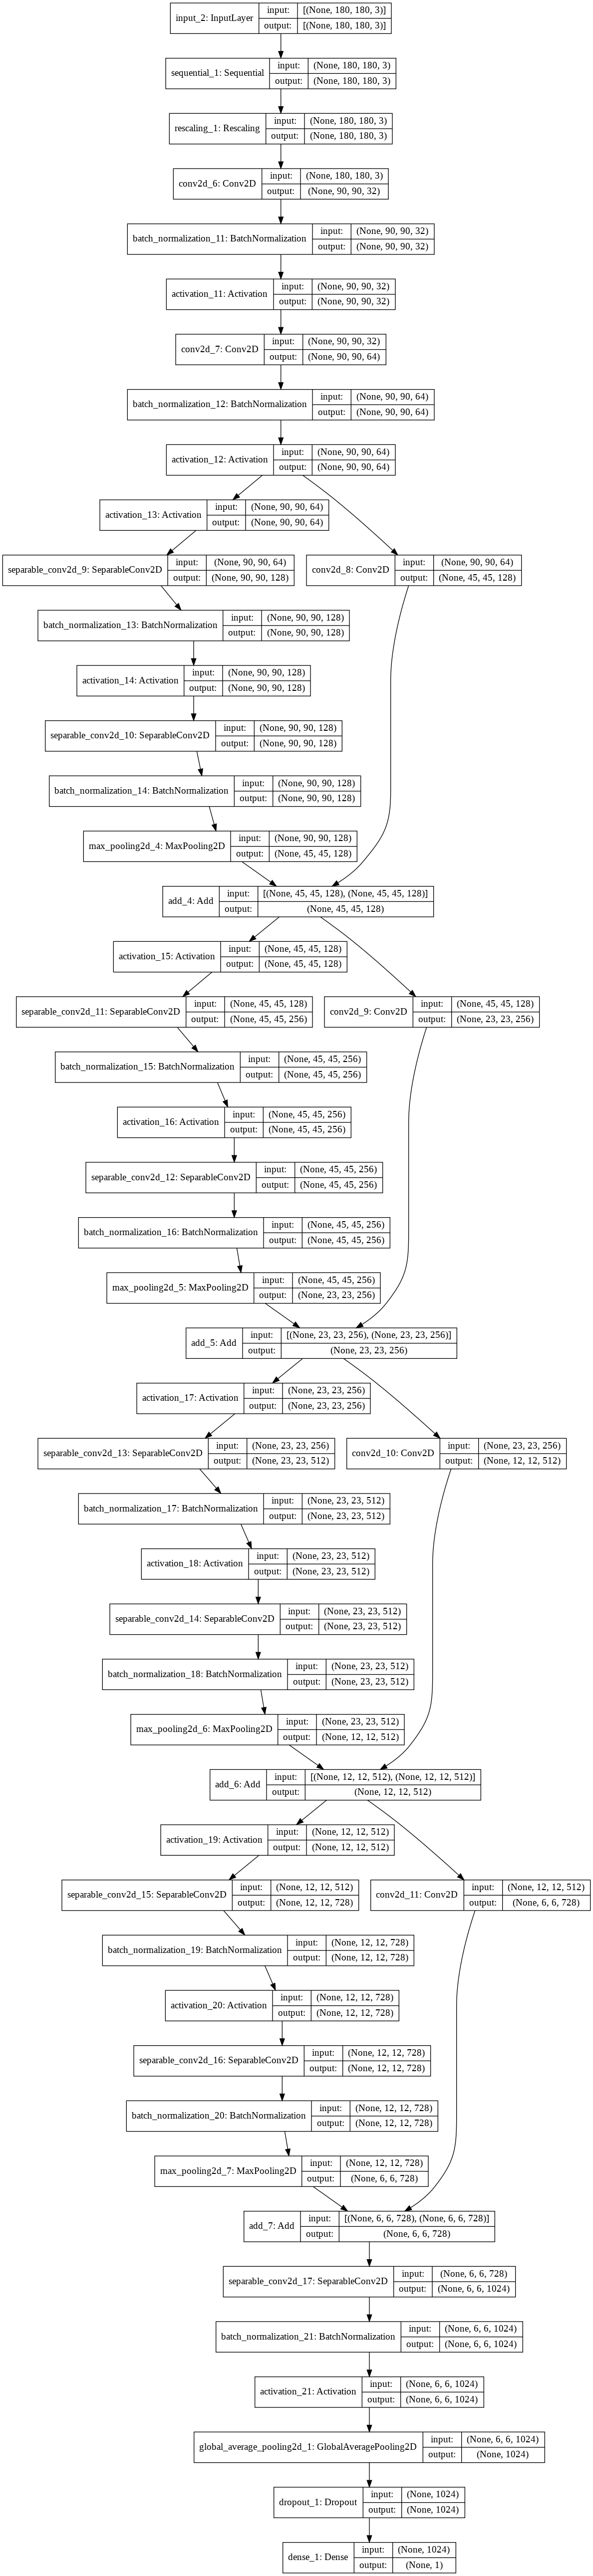

In [32]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [33]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - 116s 193ms/step - loss: 0.6875 - accuracy: 0.6180 - val_loss: 0.6971 - val_accuracy: 0.5899
Epoch 2/5
586/586 [==============================] - 112s 191ms/step - loss: 0.5011 - accuracy: 0.7593 - val_loss: 0.3850 - val_accuracy: 0.8326
Epoch 3/5
586/586 [==============================] - 112s 191ms/step - loss: 0.3960 - accuracy: 0.8226 - val_loss: 0.4704 - val_accuracy: 0.7717
Epoch 4/5
586/586 [==============================] - 112s 190ms/step - loss: 0.3268 - accuracy: 0.8615 - val_loss: 0.2458 - val_accuracy: 0.8971
Epoch 5/5
586/586 [==============================] - 112s 190ms/step - loss: 0.2652 - accuracy: 0.8853 - val_loss: 0.2334 - val_accuracy: 0.9011


# Original Problem (PyTorch)

In [38]:
!pip install pytorch_lightning


In [39]:
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

In [40]:
class smallAndSmartModel(pl.LightningModule):
    def __init__(self):
        super(smallAndSmartModel, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,28,kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(28,10,kernel_size=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.dropout1=torch.nn.Dropout(0.25)
        self.fc1=torch.nn.Linear(250,18)
        self.dropout2=torch.nn.Dropout(0.08)
        self.fc2=torch.nn.Linear(18,10)
      #This contains the manupulation on data that needs to be done only once such as downloading it
    def prepare_data(self):
        MNIST(os.getcwd(), train=True, download =True)
        MNIST(os.getcwd(), train=False, download =True)
    
    def train_dataloader(self):
        #This is an essential function. Needs to be included in the code
        #See here i have set download to false as it is already downloaded in prepare_data
        mnist_train=MNIST(os.getcwd(), train=True, download =False,transform=transforms.ToTensor())
        
        #Dividing into validation and training set
        self.train_set, self.val_set= random_split(mnist_train,[55000,5000])
        
        return DataLoader(self.train_set,batch_size=128)
        
    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(self.val_set, batch_size=128)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=False, download=False, transform=transforms.ToTensor()), batch_size=128)
    
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.dropout1(x)
        x=torch.relu(self.fc1(x.view(x.size(0), -1)))
        x=F.leaky_relu(self.dropout2(x))
        
        return F.softmax(self.fc2(x))

    def configure_optimizers(self):
        # Essential fuction
        #we are using Adam optimizer for our model
        return torch.optim.Adam(self.parameters())
    
    def configure_optimizers(self):
        # Essential fuction
        #we are using Adam optimizer for our model
        return torch.optim.Adam(self.parameters())
        
    def training_step(self,batch,batch_idx):
          
          #extracting input and output from the batch
          x,labels=batch
          
          #doing a forward pass
          pred=self.forward(x)
          
          #calculating the loss
          loss = F.nnl_loss(pred, labels)
          
          #logs
          logs={"train_loss": loss}
          
          output={
              #REQUIRED: It ie required for us to return "loss"
              "loss": loss,
              #optional for logging purposes
              "log": logs
          }
          
          return output
        

In [ ]:
#abstracts the training, val and test loops

#using one gpu given to us by google colab for max 40 epochs
myTrainer=pl.Trainer(gpus=1,max_nb_epochs=100)

model=smallAndSmartModel()
myTrainer.fit(model)

# Trying different PyTorch (Cifar10)

Used this guide: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


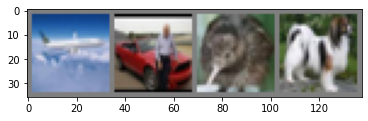

plane   car  bird   dog


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.244
[1,  4000] loss: 1.862
[1,  6000] loss: 1.658
[1,  8000] loss: 1.571
[1, 10000] loss: 1.483
[1, 12000] loss: 1.439
[2,  2000] loss: 1.355
[2,  4000] loss: 1.349
[2,  6000] loss: 1.307
[2,  8000] loss: 1.293
[2, 10000] loss: 1.275
[2, 12000] loss: 1.240
Finished Training
